# GEMS PRISM-normals Tutorial

### Section 1: Establish connection and explore available data

In [1]:
# Imports used in this notebook
from requests import Session

import pandas as pd
import rasterio
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('..')

# Import your API key from a file
from api_key import key
# from keys import write_key

# Establish connection
s = Session()
api_url = 'https://exchange-1.gems.msi.umn.edu/climate/v2/PRISM-normals'
s.headers.update({'apikey': key})

# api_url = 'https://exchange-0.msi.umn.edu/climate/v2/PRISM-normals'
# s.headers.update({'x-write-key': write_key})

# Define bounding box by string of "upper left lon, lat, bottom right lon, lat" in decimal degrees, no spaces
bbox = '-93.447444,48.65009,-88.83762,45.17553'

# Sample AOI of the upper midwest
aoi = {"type": "Polygon", "coordinates":
     [[[-90.86257188625456, 46.88471631149375],
       [-90.21090204846868, 47.84867191684921],
       [-90.13229204839561, 47.986461643867216],
       [-91.31830244956424, 47.81423854488315],
       [-91.43583296326011, 47.408369403885246],
       [-92.38327281856216, 46.879798020360425],
       [-91.9971011307051, 46.54594590211718],
       [-90.86257188625456, 46.88471631149375]]]}

In [2]:
# List available variables

res = s.get(f'{api_url}/layer')
variables = pd.json_normalize(res.json())
display(variables)

,name,units,description,discrete,id
0,Precipitation,mm,Monthly total precipitation (rain+melted snow),False,75
1,Maximum temperature,degrees C,Daily maximum temperature [averaged over all d...,False,76
2,Minimum temperature,degrees C,Daily minimum temperature [averaged over all d...,False,77
3,Mean temperature,degrees C,"Daily mean temperature, calculated as (tmax+tm...",False,78
4,Mean dew point temperature,degrees C,Daily mean dew point temperature [averaged ove...,False,79
5,Minimum vapor pressure deficit,hPa,Daily minimum vapor pressure deficit [averaged...,False,80
6,Maximum vapor pressure deficit,hPa,Daily maximum vapor pressure deficit [averaged...,False,81
7,Shortwave solar radiation horizontal,MJ per square meter per day,Total daily global shortwave solar radiation r...,False,82
8,Shortwave solar radiation sloped,MJ per square meter per day,Total daily global shortwave solar radiation r...,False,83
9,Shortwave solar radiation horizontal clear,MJ per square meter per day,Total daily global shortwave solar radiation r...,False,84


In [3]:
# Use the name of a variable to programmatically get its ID

variable_id = variables.loc[variables['name'] == 'Maximum temperature', 'id'].iloc[0]

# Get ID for a specific raster by time key name
t_key = '30-year September normal (1991-2020)' # Follow this pattern for all months, or 30-year annual normals for all months
res = s.get(f'{api_url}/object/search', params={'layer': variable_id}).json()
raster_id = next((res[i]['id'] for i in range(len(res)) if res[i]['t_key'] == t_key), 'No matches for that t_key')
print('Raster ID:', raster_id)

Raster ID: 186832


In [4]:
# Get metadata for a raster ID

metadata = s.get(f'{api_url}/object/{raster_id}')
metadata_df = pd.json_normalize(metadata.json())
display(metadata_df)

name = metadata_df['name'].iloc[0]
layer_id = metadata_df['layer_id'].iloc[0]
description = metadata_df['description'].iloc[0]
units = metadata_df['units'].iloc[0]
t_key = metadata_df['t_key'].iloc[0]
t_desc = metadata_df['t_description'].iloc[0]
time_range = metadata_df['t_ranges']
t_start, t_end = time_range[0][0]['begin'], time_range[0][len(time_range[0])-1]['begin']
print('Variable name:', name, '\n'
      'Variable ID:', layer_id, '\n'
      'Raster ID:', raster_id, '\n'
      'Description:', description, '\n'
      'Units:', units, '\n'
      'Time key :', t_key, '\n'
      'Time key description:', t_desc, '\n'
      'Number of time steps:', len(time_range[0]), '\n'
      'Begin time:', t_start, '\n'
      'End time', t_end
      )

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,186832,3,"[{'begin': '1991-09', 'end': '1991-10'}, {'beg...",30-year September normal (1991-2020),Average of all September values from 1991-2020,Maximum temperature,degrees C,Daily maximum temperature [averaged over all d...,76


Variable name: Maximum temperature 
Variable ID: 76 
Raster ID: 186832 
Description: Daily maximum temperature [averaged over all days in the month] 
Units: degrees C 
Time key : 30-year September normal (1991-2020) 
Time key description: Average of all September values from 1991-2020 
Number of time steps: 30 
Begin time: 1991-09 
End time 2020-09


### Section 2: Explore values for a single raster

In [5]:
# Get the value at a lat, lon point

params = {'lat': 46.1, 'lon': -93.7}

point_value = s.get(f'{api_url}/object/{raster_id}/point', params=params).json()['value']
print(f'Raster value at {params["lat"]}, {params["lon"]}:', point_value)

Raster value at 46.1, -93.7: 20.684499740600586


In [6]:
# Get summary statistics of values in a geoJSON area of interest
# Any bounding box query can be converted to a geoJSON query
# by changing the request type from 'get' to 'post', and
# adding the 'json' keyword argument set to your geoJSON AOI
#
# Note if the result returned is 'None' is likely that your AOI
# did not intersect the center of a cell. Try the point function.

res = s.post(f'{api_url}/object/{raster_id}/stats', json=aoi)
stats_df = pd.json_normalize(res.json())
display(stats_df)

,count,sum,mean,stddev,min,max
0,8472,157159.441444,18.550453,0.639548,16.529999,20.234299


In [7]:
# Calculate the quantiles of the raster cell values in a bounding box

params = {'bbox': bbox,
          'q': [0, 0.1, 0.3, 0.5, 0.9, 1]} # Omit 'q' parameter for default of [0, 0.25, 0.5, 0.75, 1]
res = s.get(f'{api_url}/object/{raster_id}/quantiles', params=params)
quantiles_df = pd.json_normalize(res.json())
display(quantiles_df)

,quantile,value
0,0.0,15.560699
1,0.1,18.463659
2,0.3,19.244499
3,0.5,19.761900
4,0.9,21.264419
5,1.0,22.959900


,min,max,count,percent
0,15.560699,16.382833,297,0.002814
1,16.382833,17.204966,1419,0.013444
2,17.204966,18.027100,2953,0.027978
3,18.027100,18.849233,11854,0.112308
4,18.849233,19.671366,32211,0.305176
5,19.671366,20.493500,29934,0.283603
6,20.493500,21.315633,17434,0.165174
7,21.315633,22.137767,7213,0.068338
8,22.137767,22.959900,2234,0.021166


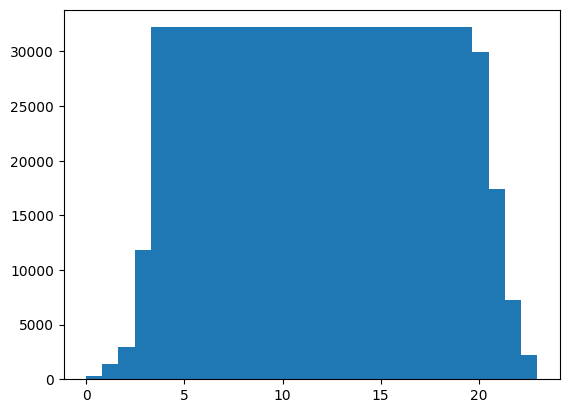

In [8]:
# Make a histogram raster cell values in a bounding box

params = {'bbox': bbox,
          'nbin': 9} # Omit 'nbin' parameter for default of 14
res = s.get(f'{api_url}/object/{raster_id}/histogram', params=params)
df = pd.json_normalize(res.json())
display(df)

# The dataframe returned is already formatted as a histogram, so we plot it as a bar chart
bar_width = df['max'].iloc[0] # Set bar width equal to bin size
plt.bar(df['max']-(bar_width/2), df['count'], width=bar_width)
plt.show()

### Section 3: View and download a subset of an individual raster

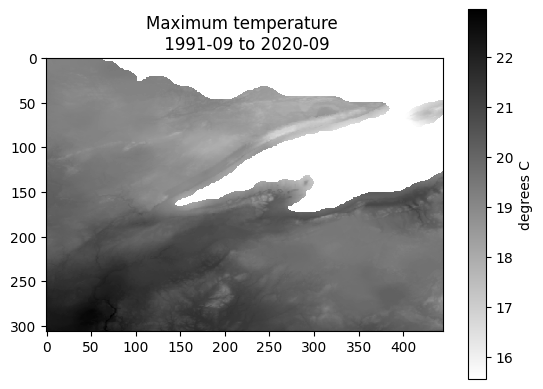

In [9]:
# Visualize the area of a raster within a bounding box

params = {'bbox': bbox}
res = s.get(f'{api_url}/object/{raster_id}/raster', params=params)

# Open the response as a memory file and plot it
with rasterio.MemoryFile(res.content) as memfile:
    with memfile.open() as dataset:
        data = dataset.read(1)
        data = np.ma.masked_where(data == dataset.nodata, data)
        palette = plt.cm.gray_r.copy()
        plt.imshow(data, cmap=palette)
        plt.title(f'{name} \n {t_start} to {t_end}')
        plt.colorbar(label=units)
    plt.show()

In [10]:
# Download a subset of the raster defined by a bounding box

params= {'bbox': bbox}

res = s.get(f'{api_url}/object/{raster_id}/raster', params=params)
out_path = 'raster_subset.tif' # Change to a local path

with rasterio.MemoryFile(res.content) as memfile:
    with memfile.open() as raster:
        with rasterio.open(out_path, 'w', **raster.profile) as dst:
            dst.write(raster.read(1), 1) # Read the first band (DEM data are single band) of the raster and write to first band of file

### Section 4: Create tabular data for an AOI

In [11]:
# Construct a dataframe with columns for average precip, minimum temperature, and max temperature
# for growing season months (May through September), for an AOI.

var_list = ['Precipitation',
            'Minimum temperature',
            'Maximum temperature'
            ]

res = s.get(f'{api_url}/layer').json()
variables = pd.json_normalize(res)

rows = []

growing_season_months = [5, 6, 7, 8, 9]
year = 1995  # All years in a climate normals dataset have the same value

for month in growing_season_months:
    start_date = f'{year}-{str(month).zfill(2)}'
    end_date = f'{year}-{str(month+1).zfill(2)}'

    params = {
          'begin': start_date,
          'end': end_date}

    t_key = s.get(f'{api_url}/object/search', params=params).json()[0]['t_key']
    row = {'time': t_key}

    for var in var_list:
        params['layer'] = variables.loc[variables['name'] == var, 'id'].iloc[0]
        raster_id = s.get(f'{api_url}/object/search', params=params).json()[0]['id']
        var_value = s.post(f'{api_url}/object/{raster_id}/stats', json=aoi).json()['mean']
        row[var] = var_value

    rows.append(row)

df = pd.DataFrame.from_dict(rows)
display(df)

,time,Precipitation,Minimum temperature,Maximum temperature
0,30-year May normal (1991-2020),81.958682,-1.233094,9.106516
1,30-year June normal (1991-2020),790.921089,-1.233094,20.368627
2,30-year July normal (1991-2020),790.921089,-1.233094,23.849080
3,30-year August normal (1991-2020),84.585698,-1.233094,23.283471
4,30-year September normal (1991-2020),87.475524,-1.233094,18.550453
